In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from math import sqrt
from numpy import linalg as LA

# Лабораторная работа №1

## Utils

### Полезные ссылки:
- [описание лабы](http://mathdep.ifmo.ru/wp-content/uploads/2021/02/lab_1_optimization.pdf)

####  Методы одномерного поиска
- [теория 1 таски](http://mathdep.ifmo.ru/wp-content/uploads/2020/09/lec_1_optimization.pdf)
- [+ 1 таске](http://machinelearning.ru/wiki/index.php?title=Метод_золотого_сечения._Симметричные_методы)

#### Градиентный спуск
- [градиентный спуск](http://fourier.eng.hmc.edu/e176/lectures/ch3/node7.html)
- [еще один такой](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%81%D0%BF%D1%83%D1%81%D0%BA%D0%B0)
- [и тут еще](http://www.apmath.spbu.ru/ru/staff/abbasov_m_e/files/MO1.pdf)
- [линейный поиск](http://fourier.eng.hmc.edu/e176/lectures/ch3/node8.html)

#### Градиентный спуск для квадратичных функций
- [симметричные матрицы и квадратичные формы](http://math.ucdenver.edu/~esulliva/LinearAlgebra/SlideShows/07_02.pdf)

### Test data

In [2]:
funcs = [ 
    lambda x: x**2,
    lambda x: 3*x + 2*x**2, 
    lambda x: 1 + 5*x + 3*x**3
]

dfs = [
    lambda x: 2*x,
    lambda x: 3 + 4*x, 
    lambda x: 5 + 9*x**2
]

a = -10
b = 5
aa = [-50, -20, -5]
bb = [20, 10, 5]
eps = [1e-3, 1e-4, 1e-6]

tt_matrices = [
    np.array([[4,0],[0,3]]),
    np.array([[-3,1],[1,2]]),
    np.array([[2,0],[0,-2]]),
]

tt_xs_start = [
    [3., -1.],
    [-1, 0.],
]

n_matrices = [
    np.array([[4,0],[0,3]]),
    np.array([[-4,1],[1,2]]),
    np.array([[1,-1,2],[-1,2,6],[2,6,3]]),
    np.array([[1,3,0],[3,2,6],[0,6,5]]),
]

n_xs_start = [
    [2., -1.],
    [-2., -4.],
    [1., 1., 1.],
    [2., 0., 1.]
]

colors = ['red', 'green', 'blue']

### Minor utils functions

In [3]:
def get_function_from_symmetric_matrix(Q):
    # [[4, 1], [1, 3]]  == 4x1^2 + 2x1x2 + 3x2^2
    
    return lambda x, y: (x**2)*Q[0][0] + 2*x*y*Q[0][1] + (y**2)*Q[1][1]

### For visualization

In [4]:
def print_iter(n_iter, a, b):
    print(str(n_iter) + ': ' + '[' + str(a) + ', ' + str(b) + ']')

In [5]:
def print_res(res, iters, func_iters):
    print('Result:', res)
    print('Total iterations: ', iters)
    print('Total function computations: ', func_iters)

In [6]:
def print_grad_res(res, step, grad_xs, c):
    print('Result:', res)
    print('Total gradient descent iterations: ', step)
    print('Gradient descent steps: ', grad_xs)
    print('Condition number: ', c)

In [7]:
def draw_countors_plot_with_gradient_steps(Q, grad_coords):
    x_min = -5
    y_min = -5
    x_max = 5
    y_max = 5
    delta = 20
    
    
    x = np.linspace(x_min, x_max, delta)
    y = np.linspace(y_min, y_max, delta)

    X, Y = np.meshgrid(x, y)
    z = get_function_from_symmetric_matrix(Q) 
    Z = z(X, Y)

    contours = plt.contour(X, Y, Z, 3, colors='black')
    plt.clabel(contours, inline=True, fontsize=12)
    plt.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin='lower',
               cmap='RdGy', alpha=0.5)
    plt.colorbar();

    gx, gy = zip(*grad_coords)
    plt.plot(gx, gy, color='black', marker='o')
    #plt.savefig('gradient_steps.png')
    plt.show()

## Методы одномерного поиска

$a < x_1 < x_2 < b$, \
$f$ — унимодальная
- если $f(x_1) < f(x_2)$, то минимум на отрезке $[a, x_2]$
- если $f(x_1) > f(x_2)$, то минимум на отрезке $[x_1, b]$
- если $f(x_1) == f(x_2)$, то минимум на отрезке $[x_1, x_2]$

In [8]:
def get_value(fdict, f, x: float):
    if (x not in fdict):
        v = f(x)
        fdict[x] = v
    else:
        v = fdict[x]
    
    return v, fdict

In [9]:
def get_next_interval_base(fdict, f, a: float, b: float, x1: float, x2: float):
    v1, fdict = get_value(fdict, f, x1)
    v2, fdict = get_value(fdict, f, x2)
    
    if (v1 < v2):
        return fdict, a, x2
    elif (v1 > v2):
        return fdict, x1, b
    else:
        return fdict, x1, x2

### Метод дихотомии 
- дихотомия — деление отрезка на 2 части
- сходимость метода всегда равна сходимости в наихудшем случае.

In [10]:
def bisection_search(f, a, b, verbose=False, eps=1e-3):
    fdict = {}
    step = 0
    delta = eps/4
    
    if (verbose):
        print_iter(step, a, b)
        
    while (abs(a - b) > eps):
        x1 = ((a + b) / 2) - delta
        x2 = ((a + b) / 2) + delta
        fdict, a, b = get_next_interval_base(fdict, f, a, b, x1, x2)
        step += 1
        if (verbose):
            print_iter(step, a, b)
       
    return (a+b)/2, step, len(fdict)

In [11]:
res, iters, func_iters = bisection_search(funcs[0], a, b)

print_res(res, iters, func_iters)

Result: -7.041931152195852e-06
Total iterations:  15
Total function computations:  30


### Метод золотого сечения
- если был интервал $x_2 \in (x_1, x_3)$, то мы хотим поместить новую точку $x_4$ внутри интервала симметрично относительно $x_2$
- золотое сечение: $\frac{b - a}{b - x_1} = \frac{x_2 - a}{x_1 - a} =  \frac{b - x_1}{b - x_2} = \frac{b - x_1}{x_1 - a} = \frac{1+\sqrt5}{2}$
- $\frac{b - a}{x_1 - a} = \frac{1+\sqrt5}{2}$ 
- $\frac{b - a}{b - x_2} = \frac{1+\sqrt5}{2}$ 
- если первернуть, будет: $\frac{-1+\sqrt5}{2}$
- $x_1$ -  точка золотого сечения отрезка $[a, x_2]$
- $x_2$ -  точка золотого сечения отрезка $[x_1, b]$
- [метод золотого сечения](http://fourier.eng.hmc.edu/e176/lectures/ch3/node3.html)

In [12]:
def golden_section_search(f, a, b, verbose=False, eps=1e-3):
    fdict = {}
    step = 0
    gold = (1+sqrt(5))/2
    
    if (verbose):
        print_iter(step, a, b)
    delta = (b-a)/gold
    x1 = b - delta
    x2 = a + delta
    
    while (abs(a - b) > eps):
        fdict, a, b = get_next_interval_base(fdict, f, a, b, x1, x2)
        delta = (b-a)/gold
        if (a == x1):
            x1 = x2
            x2 = a + delta
        else:
            x2 = x1
            x1 = b - delta
        step += 1
        if (verbose):
            print_iter(step, a, b)

    return (a+b)/2, step, len(fdict)

In [13]:
res, iters, func_iters = golden_section_search(funcs[0], a, b)

print_res(res, iters, func_iters)

Result: 0.00016526740337958101
Total iterations:  20
Total function computations:  21


### Метод Фибоначчи

- то же, что и в золотом сечение, только коэффициенты другие
- [метод фибоначчи](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%A4%D0%B8%D0%B1%D0%BE%D0%BD%D0%B0%D1%87%D1%87%D0%B8)
- $F_n = \frac{1}{\sqrt5}((\frac{1+\sqrt5}{2})^n - (\frac{1-\sqrt5}{2})^n), n = 1, 2, ..$
- $\frac{b-a}{\epsilon} < F_{n+2}$
- $n$ — кол-во вычислений фунции

In [14]:
def fib(n):
    return 1/sqrt(5) * (((1+sqrt(5))/2)**n - ((1-sqrt(5))/2)**n)

In [15]:
def fib_search(f, a, b, verbose=False, eps=1e-3):
    fdict = {}
    
    n = 0
    while (fib(n+2) <= (b-a)/eps):
        n += 1
    
    if (verbose):
        print_iter(0, a, b)
    x1 = a + fib(n)*(b-a)/fib(n+2)
    x2 = a + fib(n+1)*(b-a)/fib(n+2)
    step = 1
    
    while (abs(a - b) > eps and step <= n-2):
        fdict, a, b = get_next_interval_base(fdict, f, a, b, x1, x2)
        if (a == x1):
            x1 = x2
            x2 = a + fib(n-step+2)*(b-a)/fib(n-step+3)
        else:
            x2 = x1
            x1 = a + fib(n-step+1)*(b-a)/fib(n-step+3)
        if (verbose):
            print_iter(step, a, b)
        step += 1
        
    return (a+b)/2, step-1, len(fdict)

In [16]:
res, iters, func_iters = fib_search(funcs[2], a, b)

print_res(res, iters, func_iters)

Result: -9.998691419206247
Total iterations:  18
Total function computations:  19


### Statistics

In [17]:
methods = {'bisection_search': bisection_search, 
           'golden_section_search': golden_section_search, 
           'fib_search': fib_search}

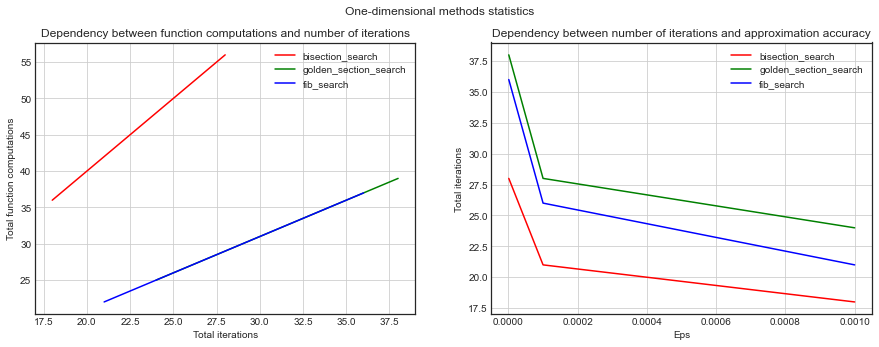

In [18]:
all_iters = {}
all_func_comps = {}

f = funcs[2]
for name, m in methods.items():
    all_iters[name] = []
    all_func_comps[name] = []
    for e in eps:
        res, iters, func_comps = m(f, aa[0], bb[0], False, e)
        all_iters[name].append(iters)
        all_func_comps[name].append(func_comps)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('One-dimensional methods statistics')
fig.set_figheight(5)
fig.set_figwidth(15)

i = 0
for name in methods.keys():
    ax1.plot(all_iters[name], all_func_comps[name], color = colors[i])
    i += 1
ax1.legend(methods.keys())
ax1.set_title('Dependency between function computations and number of iterations')
ax1.set_xlabel('Total iterations')
ax1.set_ylabel('Total function computations')
ax1.grid(True)
# ax1.show()

i = 0
for name in methods.keys():
    ax2.plot(eps, all_iters[name], color = colors[i])
    i += 1
ax2.legend(methods.keys())
ax2.set_title('Dependency between number of iterations and approximation accuracy')
ax2.set_xlabel('Eps')
ax2.set_ylabel('Total iterations')
ax2.grid(True)
plt.show()

#fig.savefig('one_dim_methods_stats.png')

## Метод градиентного спуска

- если гладкая функция $f(x)$ ограничена снизу, ее градиент $f'(x)$ удовлетворяет условию Липшица, то тогда при выбранных с помощью МНСК $\lambda_k$: $||f'(x^k)|| \to 0$ при $k \to inf$

### Градиентный спуск для одномерных функций

In [19]:
def gradient_descent(f, df, optimizer, x, eps):
    step = 0
    fcomps = 0
    niters = 0
    while (abs(df(x)) > eps):
        phi = lambda lr: f(x - lr*df(x))
        optimal_lr, iters, fcomp = optimizer(phi, 0, 1, False, eps)
        x -= optimal_lr * df(x)
        step += 1
        fcomps += fcomp
        niters += iters
        
    return x, niters, fcomps, step

In [20]:
res, iters, func_comps, grad_steps = gradient_descent(funcs[0], dfs[0], fib_search, 10, 0.01)

print_res(res, iters, func_comps)
print('Gradient descent steps:', grad_steps)

Result: 0.0007312747008064863
Total iterations:  16
Total function computations:  18
Gradient descent steps: 2


#### Statistics

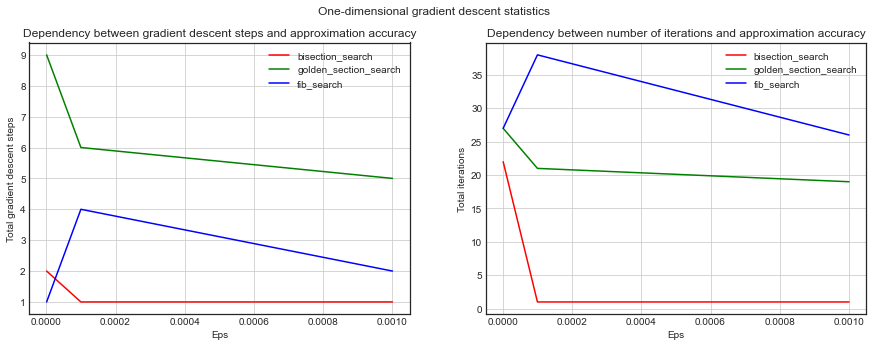

In [21]:
all_iters = {}
all_grad_steps = {}

f = funcs[2]
for name, m in methods.items():
    all_iters[name] = []
    all_grad_steps[name] = []
    for e in eps:
        res, iters, func_comps, grad_steps = gradient_descent(funcs[0], dfs[0], m, 10, e)
        all_iters[name].append(iters)
        all_grad_steps[name].append(grad_steps)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('One-dimensional gradient descent statistics')
fig.set_figheight(5)
fig.set_figwidth(15)

i = 0
for name in methods.keys():
    ax1.plot(eps, all_grad_steps[name], color = colors[i])
    i += 1
ax1.legend(methods.keys())
ax1.set_title('Dependency between gradient descent steps and approximation accuracy')
ax1.set_xlabel('Eps')
ax1.set_ylabel('Total gradient descent steps')
ax1.grid(True)
# ax1.show()

i = 0
for name in methods.keys():
    ax2.plot(eps, all_iters[name], color = colors[i])
    i += 1
ax2.legend(methods.keys())
ax2.set_title('Dependency between number of iterations and approximation accuracy')
ax2.set_xlabel('Eps')
ax2.set_ylabel('Total iterations')
ax2.grid(True)
plt.show()

#fig.savefig('one_dim_gradient_stats.png')

### Градиентный спуск для квадратичной функции 

- $F(z) = \frac{1}{2}(Qz, z) + (c, z)$
- Q -- симметричная матрица порядка $n$
- c -- заданный вектор
- $grad f(x) = Qx$

In [22]:
def get_eigenvalues(Q: np.ndarray):
    return LA.eigvals(Q)

In [23]:
def get_condition_num(Q):
    eigs = get_eigenvalues(Q)
    min_eig = min(eigs)
    max_eig = max(eigs)
    c = max_eig/min_eig
    return c

#### С оптимальным learning rate

In [24]:
def quadratic_gradient_descent_optimal(Q: np.ndarray, x, eps):
    step = 0
    xs = [x]
    c = get_condition_num(Q)
    
    while (np.linalg.norm(Q * x) > eps):
        optimal_lr = (c - 1)/(c + 1)
        diff = np.linalg.norm(np.eye(len(Q)) - optimal_lr*Q)*np.array(x)
        x -= diff
        xs.append(list(x))
        step += 1
        
    return x, step, xs, c

In [25]:
res, steps, grad_coords, cond = quadratic_gradient_descent_optimal(tt_matrices[0], tt_xs_start[0], 0.1)

print_grad_res(res, steps, grad_coords, cond)

Result: [ 0.01999167 -0.00666389]
Total gradient descent iterations:  4
Gradient descent steps:  [[3.0, -1.0], [0.8571428571428572, -0.2857142857142857], [0.24489795918367352, -0.08163265306122447], [0.06997084548104957, -0.02332361516034985], [0.019991670137442734, -0.0066638900458142435]]
Condition number:  1.3333333333333333


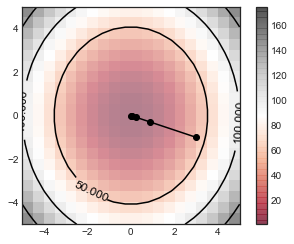

In [26]:
draw_countors_plot_with_gradient_steps(tt_matrices[0], grad_coords)

#### С константным lr

In [27]:
def quadratic_gradient_descent_constant(Q: np.ndarray, x, eps, lr=0.3):
    step = 0
    xs = [x]
    c = get_condition_num(Q)
    
    while (np.linalg.norm(Q * x) > eps):
        diff = np.linalg.norm(np.eye(len(Q)) - lr*Q)*np.array(x)
        x -= diff
        xs.append(list(x))
        step += 1
        
    return x, step, xs, c

In [28]:
res, steps, grad_coords, cond = quadratic_gradient_descent_constant(tt_matrices[0], tt_xs_start[0], 0.1, 0.3)

print_grad_res(res, steps, grad_coords, cond)

Result: [ 0.01900009 -0.00633336]
Total gradient descent iterations:  20
Gradient descent steps:  [[3.0, -1.0], [2.329179606750063, -0.7763932022500211], [1.808359213500126, -0.6027864045000421], [1.4039978005876923, -0.46799926686256416], [1.090054348350265, -0.36335144945008835], [0.8463107861422221, -0.28210359538074076], [0.6570699413516925, -0.21902331378389756], [0.5101446358682741, -0.1700482119560914], [0.39607282745244027, -0.1320242758174801], [0.30750825083002015, -0.1025027502766734], [0.23874731558022202, -0.07958243852674068], [0.18536179287192492, -0.061787264290641644], [0.1439136359426389, -0.04797121198087964], [0.11173356865694914, -0.03724452288564972], [0.08674918316839132, -0.028916394389463782], [0.06735147611268097, -0.02245049203756033], [0.05229122821539017, -0.017430409405130062], [0.04059855412373343, -0.013532851374577813], [0.031520441442846193, -0.010506813814282067], [0.02447225646814563, -0.008157418822715212], [0.019000093565587378, -0.0063333645218624

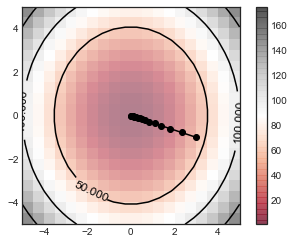

In [29]:
draw_countors_plot_with_gradient_steps(tt_matrices[0], grad_coords)

#### С вычислением оптимального на каждом шаге

In [30]:
def quadratic_gradient_descent_with_optimizer(Q: np.ndarray, x, eps, optimizer=fib_search):
    step = 0
    
    eigs = get_eigenvalues(Q)
    min_eig = min(eigs)
    max_eig = max(eigs)
    c = max_eig/min_eig
    
    grad_xs = []
    grad_xs.append(list(x))
    while (np.linalg.norm(Q * x) > eps):
        phi = lambda lr: np.linalg.norm(np.eye(len(Q)) - lr*Q)
#         optimal_lr, iters, fcomp = optimizer(phi, 0, 2/max_eig, True, eps)
        optimal_lr, iters, fcomp = optimizer(phi, 0.1, 5, False, eps)
        x -= phi(optimal_lr)*np.array(x)
        step += 1
        grad_xs.append(list(x))
        
    return x, step, grad_xs, c

In [31]:
res, steps, grad_coords, cond = quadratic_gradient_descent_with_optimizer(tt_matrices[0], tt_xs_start[0], 0.1)

print_grad_res(res, steps, grad_coords, cond)

Result: [ 0.02405803 -0.00801934]
Total gradient descent iterations:  14
Gradient descent steps:  [[3.0, -1.0], [2.125283562367876, -0.7084278541226252], [1.505610073490363, -0.5018700244967875], [1.066616113508186, -0.35553870450272856], [0.7556205644652187, -0.25187352148840614], [0.5353026550150217, -0.1784342183383405], [0.3792233111984358, -0.12640777039947854], [0.2686523565855844, -0.08955078552852809], [0.19032081248091187, -0.0634402708269706], [0.13482856478072697, -0.044942854926908964], [0.09551631082204377, -0.03183877027401458], [0.06766641510937016, -0.022555471703123376], [0.04793677325210189, -0.01597892441736729], [0.0339597454085494, -0.011319915136183129], [0.02405802956632933, -0.008019343188776439]]
Condition number:  1.3333333333333333


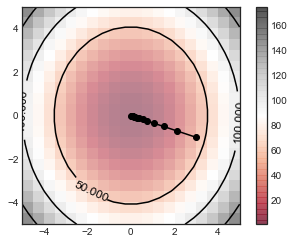

In [32]:
draw_countors_plot_with_gradient_steps(tt_matrices[0], grad_coords)

#### Statistics

In [33]:
gradient_methods = {'optimal': quadratic_gradient_descent_optimal, 
                   'constant': quadratic_gradient_descent_constant, 
                   'with optimizer': quadratic_gradient_descent_with_optimizer}

In [34]:
def get_quadratic_gradient_stats(x, alp):
    all_grad_steps = {}
    all_conds = {}
    all_prods = {}

    for name, m in gradient_methods.items():
        all_grad_steps[name] = []
        all_conds[name] = []
        for matrix in tt_matrices:
            res, steps, grad_coords, cond = m(matrix, x, 0.1)
            all_grad_steps[name].append(steps)
            all_conds[name].append(cond)

    i = 0
    for name in gradient_methods.keys():
        plt.plot(all_conds[name], all_grad_steps[name], color = colors[i], alpha = 1/alp)
        i += 1
    plt.legend(gradient_methods.keys())
    plt.title('Quadratic radient descent statistics')
    plt.xlabel('Conds')
    plt.ylabel('Total gradient descent steps')
    plt.grid(True)
    
    return plt

<ipython-input-24-9988348ffdd6>:8: RuntimeWarning: overflow encountered in multiply
  diff = np.linalg.norm(np.eye(len(Q)) - optimal_lr*Q)*np.array(x)
<ipython-input-24-9988348ffdd6>:9: RuntimeWarning: invalid value encountered in subtract
  x -= diff
<ipython-input-24-9988348ffdd6>:7: RuntimeWarning: divide by zero encountered in double_scalars
  optimal_lr = (c - 1)/(c + 1)
<ipython-input-24-9988348ffdd6>:8: RuntimeWarning: invalid value encountered in multiply
  diff = np.linalg.norm(np.eye(len(Q)) - optimal_lr*Q)*np.array(x)
<ipython-input-24-9988348ffdd6>:6: RuntimeWarning: overflow encountered in multiply
  while (np.linalg.norm(Q * x) > eps):


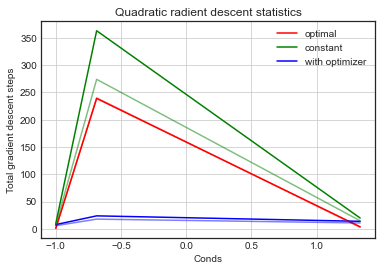

In [35]:
i = 1
for x in tt_xs_start:
    get_quadratic_gradient_stats(x, i)
    i += 1
#plt.savefig('quad_gradient_stats.png')

### Градиентный спуск в зависимости от числа обсуловленности k и кол-ва параметров n

<ipython-input-27-a3f25529e9e3>:6: RuntimeWarning: overflow encountered in multiply
  while (np.linalg.norm(Q * x) > eps):
<ipython-input-27-a3f25529e9e3>:7: RuntimeWarning: overflow encountered in multiply
  diff = np.linalg.norm(np.eye(len(Q)) - lr*Q)*np.array(x)
<ipython-input-27-a3f25529e9e3>:8: RuntimeWarning: invalid value encountered in subtract
  x -= diff
<ipython-input-27-a3f25529e9e3>:6: RuntimeWarning: invalid value encountered in multiply
  while (np.linalg.norm(Q * x) > eps):


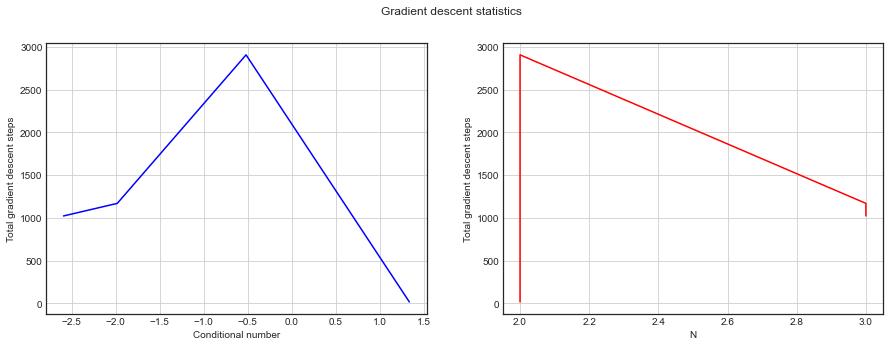

In [36]:
all_grad_steps = []
all_conds = []
all_ns = []


for i in range(len(n_matrices)):
    res, steps, grad_coords, cond = quadratic_gradient_descent_constant(n_matrices[i], n_xs_start[i], 0.1, 0.3) 
    all_grad_steps.append(steps)
    all_conds.append(cond)
    all_ns.append(len(n_matrices[i]))
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Gradient descent statistics')
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(all_conds, all_grad_steps, color = 'blue')
ax1.set_xlabel('Conditional number')
ax1.set_ylabel('Total gradient descent steps')
ax1.grid(True)

ax2.plot(all_ns, all_grad_steps, color = 'red')
ax2.set_xlabel('N')
ax2.set_ylabel('Total gradient descent steps')
ax2.grid(True)
plt.show()

#fig.savefig('cond_and_params_stats.png')